In [1]:
import sys
sys.path.append('../src/')


In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon

/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
%matplotlib inline

# Useful imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from utils.publication_functions import beautify_data_column_name
from sklearn.cluster import KMeans
from flows.specific.custom_flow import CustomFlow

# Data sources
from data_sources.specific.coca import Coca
from data_sources.specific.gold_export import GoldExport
from data_sources.specific.gold_stock_price import GoldStockPrice
from data_sources.specific.malaria_cases import Malaria
from data_sources.specific.mock_malaria_cases import MockMalaria
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.temperature_max import TemperatureMax
from data_sources.specific.temperature_min import TemperatureMin
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.precipitation_average import PrecipitationAverage
from data_sources.specific.precipitation_total import PrecipitationTotal
from data_sources.specific.deforestation_average import DeforestationAverage
from data_sources.specific.deforestation_total import DeforestationTotal
from data_sources.specific.fb_mobility import FBMobility

# Embedders
from embedders.specific.identity_embedder import IdentityEmbbeder
from embedders.specific.linear_regression_coefficient_embedder import LinearRegressionCoefficientEmbedder
from embedders.specific.mobility_to_distance_embedder import MobilityToDistanceEmbeder
from embedders.specific.mobility_to_similarity_embedder import MobilityToSimilarityEmbeder
from embedders.specific.aggregation_embedder import AggregationEmbedder

# Clusteres
from clusterers.specific.identity_clusterer import IdentityClusterer
from clusterers.specific.quantile_clusterer import QuantileClusterer
from clusterers.specific.sklearn_vector_clusterer import SklearnVectorClusterer
from clusterers.specific.two_tier_dbscan_clusterer import TwoTierDBSCANClusterer
from clusterers.specific.similarity_community_clusterer import SimilarityCommunityClusterer

# Geographies
from geography.specific.colombian_municipalities import ColombianMunicipalities
from geography.specific.choco_municipalities import ChocoMunicipalities
from geography.specific.colombia_grid import ColombianGrid
from geography.specific.colombia_rivers import ColombianRivers
from geography.general.geography_from_flow_output import GeographyFromFlowOutput
from geography.specific.colombia_indg_com import ColombianIndgCom
from geography.specific.colombia_indg_terr import ColombianIndgTerr

# Flows
from flows.specific.custom_flow import  CustomFlow

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Test flow

In [4]:
fuentes_incluidas = [GoldExport, Malaria]
target_col=target_col = 'malaria_num_cases_sum'

In [11]:
geography = ColombianMunicipalities()
geography.set_filter(filter)

In [12]:
flow = CustomFlow(ID = 'basic_analysis',
                    name = "Basic Analysis",
                    time_resolution = YEAR,
                    geography = geography,
                    vector_data_sources=fuentes_incluidas,
                    matrix_data_sources=[],
                    # embedder=IdentityEmbbeder(),
                    embedder=LinearRegressionCoefficientEmbedder(target_col=target_col),
                    clusterer=SklearnVectorClusterer(ID="kmeans", name="K-Means", sklearn_clusterer= KMeans(n_clusters=5))
                    # clusterer=IdentityClusterer()
                    )

In [13]:
flow.run()

   Starts Flow: Basic Analysis
      Loads Initial Geography
      Loads Data
         Loads Vector Data
         Found 2 elements
            Extracts 1 of 2: Gold Exports (gold_exports) 
            Extracts 2 of 2: Malaria (malaria) 
         Done
         
         Loads Matrix Data
         Found 0 elements
         Done
         ------------------
      Embedds Data
         Found 1 embedders
            Linear Regression Coefficient Embeder
      Clusters Data
      Builds Final Geometry
   Flow Ended
   Done
   -----------------


In [14]:
df_geo = flow.initial_geometry.merge(flow.df_vector)
df_geo.head()

,ID,geometry,date,gold_exports_grams_sum,malaria_num_cases_sum
0,27660,"POLYGON ((-76.09368 5.01559, -76.09359 5.01558...",2006-12-31,NaN,2.0
1,27660,"POLYGON ((-76.09368 5.01559, -76.09359 5.01558...",2007-12-31,NaN,39.0
2,27660,"POLYGON ((-76.09368 5.01559, -76.09359 5.01558...",2008-12-31,NaN,298.0
3,27660,"POLYGON ((-76.09368 5.01559, -76.09359 5.01558...",2009-12-31,NaN,333.0
4,27660,"POLYGON ((-76.09368 5.01559, -76.09359 5.01558...",2010-12-31,NaN,1084.0


<AxesSubplot:>

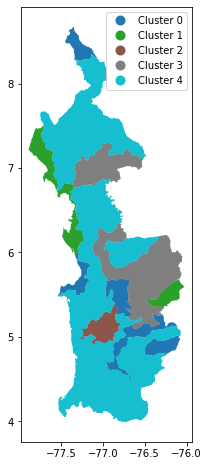

In [17]:
flow.final_geometry[CLUSTER_ID] = flow.final_geometry[ID].apply(lambda i : f"Cluster {i}")
flow.final_geometry.plot(column = CLUSTER_ID, figsize = (8,8), legend=True)

,ID,geometry,date,gold_exports_grams_sum,malaria_num_cases_sum
0,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2006-12-31,NaN,0.0
1,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2007-12-31,NaN,0.0
2,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2008-12-31,NaN,10.0
3,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2009-12-31,NaN,12.0
4,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2010-12-31,NaN,9.0


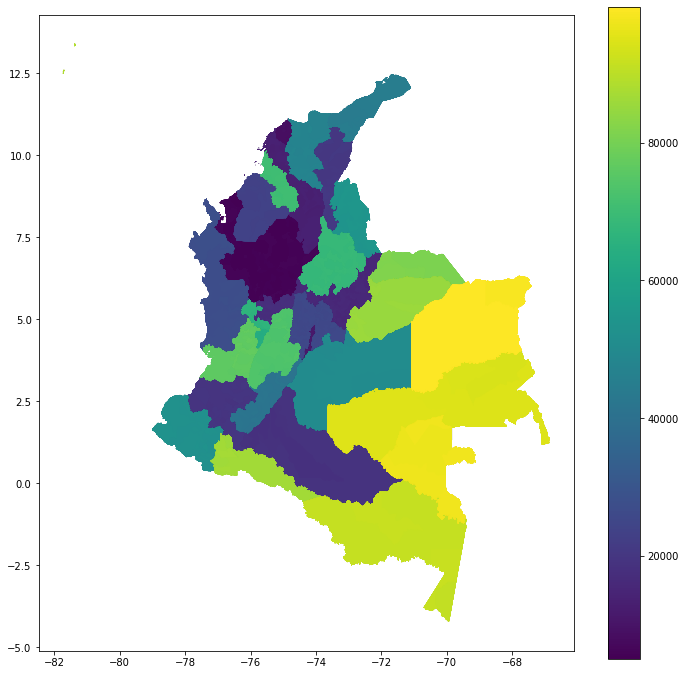

In [9]:
df_geo = flow.initial_geometry.merge(flow.df_vector)
column = 'ID'

# df_geo = df_geo[df_geo[column] > 0.05].copy()
# # df_geo.drop(columns=["left", "top", "right", "bottom"], inplace=True)
# df_geo["year"] = df_geo.apply(lambda x: x.date.year, axis=1)
# for d in df_geo["date"].unique():
#     df_geo[df_geo.date == d].plot(figsize = (12,12), column = column, legend = True)
#     break


df_geo.plot(figsize = (12,12), column = column, legend = True)
df_geo.head()

In [33]:
df_reg = df_geo.dropna().copy()
df_reg["gold_exports_norm"] = (df_reg["gold_exports_grams_sum"] - df_reg["gold_exports_grams_sum"].min()) / (df_reg["gold_exports_grams_sum"].max() - df_reg["gold_exports_grams_sum"].min())
df_reg["malaria_norm"] = (df_reg["malaria_num_cases_sum"] - df_reg["malaria_num_cases_sum"].min()) / (df_reg["malaria_num_cases_sum"].max() - df_reg["malaria_num_cases_sum"].min())
df_reg.head()



,ID,geometry,date,gold_exports_grams_sum,malaria_num_cases_sum,gold_exports_norm,malaria_norm
6,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2012-12-31,1459.0,1.0,0.000071,0.000034
7,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2013-12-31,6092.0,4.0,0.000296,0.000137
8,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2014-12-31,753.0,2.0,0.000037,0.000069
9,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2015-12-31,6660.0,1.0,0.000324,0.000034
10,5467,"POLYGON ((-75.57280 6.02282, -75.57272 6.02285...",2016-12-31,40257.0,0.0,0.001959,0.000000


## IBD matrix data source

In [5]:
from constants import DATE, ID_2, GEOMETRY, ID, PIPELINE_DATA_FOLDER, RAW, ID_1, SUB_ID, USUAL_PROJECTION, isTimeResolutionValid
from data_sources.abstract.matrix_data_source import MatrixDataSource
from utils.date_functions import get_period_representative_function


# Constants
SOURCE_ID = "ibd"
NAME = "Identity by Descent"

In [24]:
class IBD(MatrixDataSource):
    '''
    Matrix Data Source
    '''

    def __init__(self):
        super().__init__()

        self.ibd_threshold = 0.9

    @property
    def ID(self):
        return SOURCE_ID

    @property
    def name(self):
        return NAME

    def set_ibd_threshold(self, ibd_threshold):
        self.ibd_threshold = ibd_threshold



    # Override
    def createData(self, df_geo, time_resolution):

        # Checks time resolution
        isTimeResolutionValid(time_resolution)

        # Data
        data_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'ibd', 'ibd_muni.csv')
        muni_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'geo', 'municipalities', 'municipalities.shp')

        df = pd.read_csv(data_path, parse_dates=["date_1", "date_2"], sep='\t')
        gdf_muni = gpd.read_file(muni_path)

        # Takes to end of period
        df["date_1"] = df["date_1"].apply(
            get_period_representative_function(time_resolution))

        df["date_2"] = df["date_2"].apply(
            get_period_representative_function(time_resolution))

        # Drop rows where time resolution doesn't match
        df = df[df["date_1"] == df["date_2"]]
        df.drop(columns=["date_2"], inplace=True)
        df.rename(columns={"date_1": "date"}, inplace=True)

        # Group by date id1, id2, and date to get min
        df = df.groupby(["date", "ID_1", "ID_2"]).min().reset_index()

        # Adds geometry
        # First ID_1
        gdf_ibd_1 = gpd.GeoDataFrame(gdf_muni.merge(df, left_on="muni_id", right_on=ID_1).dropna().drop(columns=["muni_id"]), 
                geometry='geometry', crs=USUAL_PROJECTION)
        gdf_ibd_1 = gpd.sjoin(gdf_ibd_1, df_geo[[ID, GEOMETRY]], how='left', predicate='contains')

        # Then ID_2
        gdf_ibd_2 = gpd.GeoDataFrame(gdf_muni.merge(df, left_on="muni_id", right_on=ID_2).dropna().drop(columns=["muni_id"]), 
                geometry='geometry', crs=USUAL_PROJECTION).dropna()                
        gdf_ibd_2 = gpd.sjoin(gdf_ibd_2, df_geo[[ID, GEOMETRY]], how='left', predicate='contains').drop(['index_right', ID], axis=1)

        # Merge gdf and merge geometries by union. Resulting geometry is the union of the corresponding polygons
        gdf_ibd = gdf_ibd_1[["geometry", "date", "ID_1", "ID_2"]].merge(gdf_ibd_2, on=["date", "ID_1", "ID_2"])        

        # Transform geomtry into a grouping
        gdf_ibd["geometry"] = gdf_ibd.apply(lambda x: gpd.GeoSeries([x["geometry_x"], x["geometry_y"]]).unary_union, axis=1)
        gdf_ibd.drop(columns=["geometry_x", "geometry_y"], inplace=True)
        
        gdf_ibd = gpd.GeoDataFrame(gdf_ibd, geometry='geometry')
        return gdf_ibd

    def createDataFromCachedSubGeography(self, time_resolution, sub_geography,
                                         df_map):
        # Checks time resolution
        isTimeResolutionValid(time_resolution)

        # Gets the data from the sub_geography
        df = self.get_data(sub_geography, time_resolution)

        # Maps the ids
        # id 1
        df.rename(columns={ID_1: SUB_ID}, inplace=True)
        df = df.merge(df_map).rename(columns={ID: ID_1})
        df.drop(SUB_ID, axis=1, inplace=True)
        # Id 2
        df.rename(columns={ID_2: SUB_ID}, inplace=True)
        df = df.merge(df_map).rename(columns={ID: ID_2})
        df.drop(SUB_ID, axis=1, inplace=True)

        # Agglomerates
        df_final = df.groupby([ID_1, ID_2, DATE]).sum().reset_index()

        return (df_final)

In [25]:
muni_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'geo', 'municipalities', 'municipalities.shp')
gdf_muni = gpd.read_file(muni_path)
gdf_muni.rename(columns={"muni_id": "ID"}, inplace=True)

geography = ColombianMunicipalities()
time_resolution = MONTH

ds = IBD()
gdf_ds = ds.createData(gdf_muni, time_resolution)
gdf_ds.head()


/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of part

,date,ID_1,ID_2,ibd,geometry
0,2020-01-31,76109,19318,0.04654,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."
1,2020-01-31,76109,27001,0.26423,"MULTIPOLYGON (((-77.23164 4.16706, -77.22345 4..."
2,2020-02-29,76109,19318,0.11651,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."
3,2020-02-29,76109,76109,0.99849,"POLYGON ((-77.23164 4.16706, -77.22345 4.15799..."
4,2020-03-31,76109,19318,0.30528,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."


In [104]:

MultiPolygon([])
